In [669]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from scipy import optimize
from scipy.interpolate import interp1d

# Read data

In [670]:
%run profile_read_py.py

In [671]:
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/RM1183023.324' #30 agosto 2011

read = profile_read(arquivo)
phy  = read[1]

df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista
alt = 7.5*(np.array(df.index) + 1)

df['alt'] = alt
s355 = df['355 o analog 0']

In [672]:
df = df.set_index('alt')
df

,355 o analog 0,355 o photon 0,387 o analog 1,387 o photon 1,408 o photon 2
alt,,,,,
7.5,1.610514,135.066667,2.006006,78.700000,2.833333
15.0,1.610107,132.966667,2.006917,66.466667,2.233333
22.5,1.607259,131.233333,2.006453,62.566667,1.433333
30.0,1.609294,130.533333,2.006340,62.700000,1.566667
37.5,1.608073,125.733333,2.005892,55.833333,1.233333
...,...,...,...,...,...
29970.0,1.615804,0.000000,2.010620,0.000000,0.000000
29977.5,1.618856,0.000000,2.010539,0.033333,0.000000
29985.0,1.614583,0.000000,2.009847,0.000000,0.000000


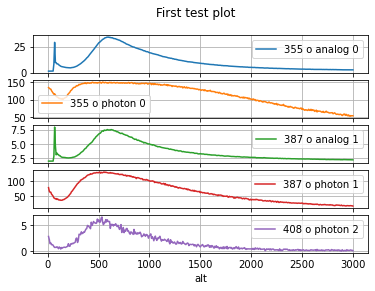

In [673]:
plot = df[:3000].plot(grid=True, subplots=True, title='First test plot')

# Reading multiple data (mean signal)

The idea here is to iterate over the data files in a month directory.

In [674]:
import os

directory = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/30'



initial = 700
final = 730

data = np.zeros((4000, final - initial))
cont = 0


for filename in os.listdir(directory)[initial:final]:
    read = profile_read(directory + '/' + filename)
    data[:, cont] = read[1][:, 0]
    phy = read[1]
    cont += 1

In [675]:
700/60

11.666666666666666

In [676]:
df = pd.DataFrame(data)
#df.columns = lista
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.610921,1.631063,1.619263,1.771444,1.594442,1.702881,1.608276,1.675008,1.583862,1.742961,...,1.613566,1.658122,1.695760,1.607463,1.632284,1.602987,1.621908,1.597697,1.720581,1.593018
1,1.614176,1.620483,1.619263,1.765951,1.596069,1.700643,1.607869,1.666260,1.586914,1.773478,...,1.618449,1.663005,1.700236,1.610311,1.631266,1.603597,1.622314,1.593221,1.707357,1.593628
2,1.609904,1.624349,1.617432,1.764526,1.598714,1.700439,1.603800,1.675618,1.585897,1.763102,...,1.617635,1.659139,1.694132,1.600749,1.636963,1.607666,1.627197,1.597290,1.700439,1.596069
3,1.612752,1.623739,1.618449,1.764730,1.584880,1.709391,1.602987,1.657104,1.587728,1.747233,...,1.614176,1.653442,1.706340,1.599731,1.628825,1.605632,1.626180,1.597697,1.701457,1.592000
4,1.608073,1.623942,1.620483,1.760661,1.590576,1.707967,1.605225,1.667480,1.586914,1.747437,...,1.617432,1.644694,1.683553,1.603190,1.630859,1.605428,1.620076,1.596883,1.714071,1.597290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.626587,1.630452,1.618042,1.777344,1.589966,1.712850,1.612549,1.671956,1.587931,1.739502,...,1.622314,1.657511,1.711222,1.607869,1.624552,1.619263,1.632487,1.602173,1.721191,1.602173
3996,1.624146,1.623739,1.616414,1.772461,1.595662,1.715495,1.612142,1.670532,1.591797,1.738281,...,1.623739,1.661987,1.687622,1.616211,1.632284,1.613159,1.628825,1.604614,1.724243,1.592204
3997,1.623739,1.634318,1.619059,1.771647,1.596273,1.714478,1.610311,1.667684,1.595256,1.757812,...,1.625163,1.660156,1.697795,1.618245,1.629435,1.612956,1.628418,1.599935,1.720581,1.597493
3998,1.623128,1.630859,1.614176,1.772054,1.596680,1.701050,1.616007,1.668294,1.594645,1.750488,...,1.626383,1.663818,1.690267,1.613770,1.632690,1.610921,1.628215,1.604818,1.710205,1.595866


In [677]:
s355 = df.mean(axis=1)
s355

0       1.639377
1       1.640042
2       1.639106
3       1.638611
4       1.638340
          ...   
3995    1.644226
3996    1.643738
3997    1.644185
3998    1.643473
3999    1.643256
Length: 4000, dtype: float64

# Applying corrections to signal data

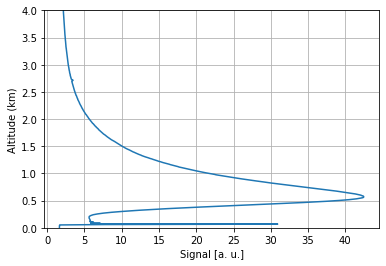

In [678]:
plt.plot(s355, alt*1e-3)
plt.grid(True)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal [a. u.]')
plt.ylim(0, 4)
plt.savefig('fig1', dpi=200)

## Picture for $log(P r^2)$

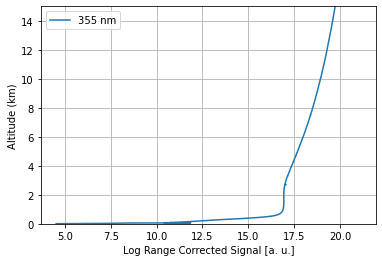

In [679]:
plt.plot(np.log(s355*alt*alt), alt*1e-3)
plt.grid(True)
plt.legend(['355 nm'])
plt.ylabel('Altitude (km)')
plt.xlabel('Log Range Corrected Signal [a. u.]')
plt.ylim(0, 15)
plt.savefig('fig3', dpi=200)

# Read temperature and pressure data

## Usando perfil artificial

z = alt
Pair = read[0]['P0']*np.exp(-(z-100)/8e3)    # H aproximadamente 8km
Tair = read[0]['T0'] - (9.8*1e-3)*z    # 6.5 lapse rate

Pair *= 100
Pair

plt.plot(Pair, alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig4', dpi=200)

Tair = read[0]['T0']+273.15 -0.006666666666668182*alt[:int(12000/7.5)]
Tair_p = Tair[-1]*np.ones(len(alt[int(12000/7.5):]))
Tair = np.concatenate((Tair, Tair_p), axis=0)

plt.plot(Tair, alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig5', dpi=200)

## Usando dados de Wyoming

In [680]:
PairTair = pd.read_fwf('PairTair.txt', header=None)

In [681]:
PairTair.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1001.0,84,28.8,22.8,70,17.81,80.0,1.0,301.9,354.7,305.1
1,1000.0,93,29.0,23.0,70,18.05,80.0,1.0,302.1,355.8,305.4
2,992.0,165,31.6,22.6,59,17.75,81.0,2.0,305.4,358.9,308.7
3,986.0,220,31.6,21.6,55,16.78,81.0,3.0,306.0,356.6,309.1
4,947.0,581,28.7,20.0,59,15.76,85.0,10.0,306.6,354.2,309.5


In [682]:
Pair = 100*PairTair[0]
Tair = 273.15 + PairTair[2]

bg = np.mean(s355[-500:])  # O background eh a media dos ultimos 500 bins
n_alt = alt[11:3145]    # Preciso ajustar o tamanho dos arrays de altitude e sinal
                        # pra poder fazer a interpolacao
n_s355 = s355[11:3145]  # '''

x = PairTair[1]
y = Pair
f = interp1d(x, y, kind='cubic')
newPair = f(n_alt)


y = Tair
f = interp1d(x, y, kind='cubic')
newTair = f(n_alt)

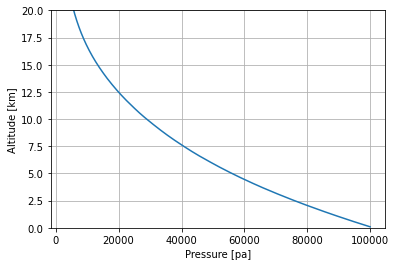

In [683]:
plt.plot(newPair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 20)
plt.savefig('Pres_profile', dpi=200)

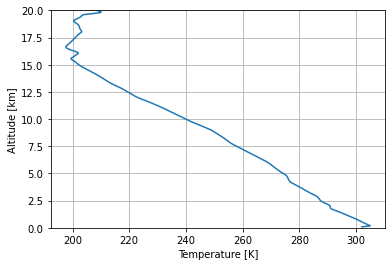

In [684]:
plt.plot(newTair, n_alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 20)
plt.savefig('Temp_profile', dpi=200)

# Molecular Scattering

In [685]:
%run alphabeta.ipynb

In [686]:
lambd = 355*1e-9
co2 = 400


alpha_mol, beta_mol, LR_mol = alphabeta(newPair, newTair, lambd, co2)

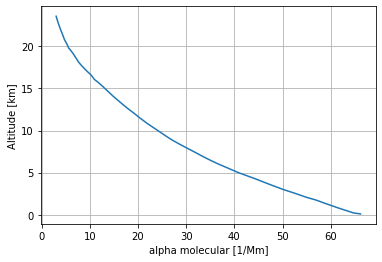

In [687]:
plt.plot(alpha_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('alpha molecular [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('fig6', dpi=200)

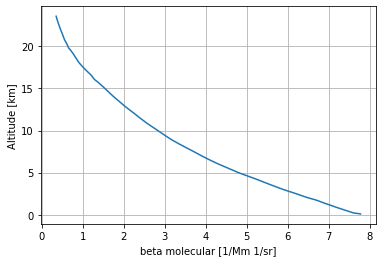

In [688]:
plt.plot(beta_mol*1e6, n_alt*1e-3)
plt.grid(True)
plt.xlabel('beta molecular [1/Mm 1/sr]')
plt.ylabel('Altitude [km]')
plt.savefig('fig7', dpi=200)

# Obtaining overlap

In [689]:
overlap = pd.read_csv('overlap_narrow.csv', header=None)
overlap

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.000077,0.000090,0.000096,0.000059,0.000063,0.000068,0.000072,0.000096,0.000062,0.000070,...,0.000076,0.000058,0.000040,0.000047,0.000053,0.000042,0.000070,0.000101,0.000112,0.000300
1,0.000107,0.000121,0.000129,0.000083,0.000089,0.000095,0.000101,0.000131,0.000088,0.000098,...,0.000106,0.000080,0.000055,0.000065,0.000073,0.000059,0.000092,0.000134,0.000149,0.000397
2,0.000140,0.000156,0.000165,0.000110,0.000118,0.000126,0.000132,0.000168,0.000117,0.000131,...,0.000139,0.000105,0.000071,0.000085,0.000096,0.000078,0.000115,0.000169,0.000189,0.000502
3,0.000179,0.000195,0.000206,0.000143,0.000154,0.000164,0.000170,0.000212,0.000152,0.000170,...,0.000180,0.000135,0.000092,0.000110,0.000123,0.000101,0.000143,0.000209,0.000234,0.000621
4,0.000224,0.000240,0.000252,0.000181,0.000194,0.000206,0.000213,0.000260,0.000193,0.000216,...,0.000225,0.000169,0.000115,0.000138,0.000154,0.000127,0.000172,0.000251,0.000283,0.000751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1996,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1997,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1998,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


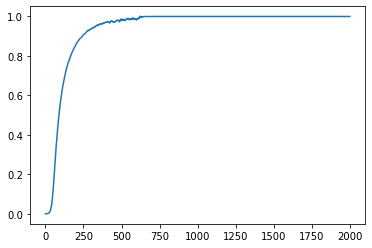

In [690]:
plt.plot(overlap[0])

# built the simulated molecular signal

In [691]:
s355 = s355 - bg          # Subtraindo o background
s355 = np.concatenate((s355[:2000]/overlap[0], s355[2000:]), axis=0)   #Dividindo pelo overlap
n_alt = alt[11:3145]
n_s355 = s355[11:3145]

In [692]:
meteo_alt = n_alt

In [693]:
model = (beta_mol * np.exp(-2*integrate.cumtrapz(alpha_mol, meteo_alt, initial=0))) / meteo_alt**2

(1e-10, 1000000000000000.0)

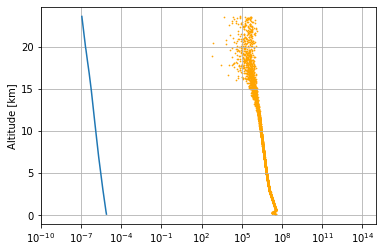

In [694]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, s=0.5, c='orange')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)

## Determinando a região do ajuste

In [695]:
alt_min = 8.   # km
alt_max = 15   # km

index_min = int(alt_min*1e3/7.5)
index_max = int(alt_max*1e3/7.5)

Text(0, 0.5, 'Measured signal')

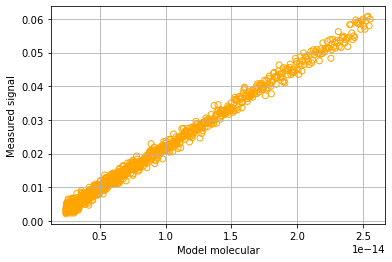

In [696]:
plt.scatter(model[index_min:index_max], s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

In [697]:
f = lambda x, a, b: a*x + b

fit = optimize.curve_fit(f, model[index_min:index_max], n_s355[index_min:index_max], p0=(1e13, 116))

a = fit[0][0]
b = fit[0][1]

fit

(array([ 2.34200664e+12, -2.28336310e-03]),
 array([[ 3.94527044e+19, -3.63144047e+05],
        [-3.63144047e+05,  4.84599391e-09]]))

Text(0, 0.5, 'Measured signal')

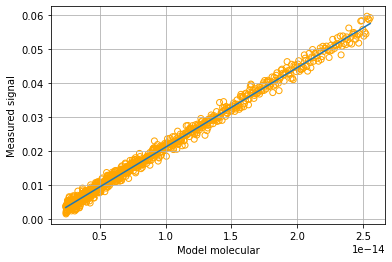

In [698]:
plt.scatter(model[index_min:index_max], n_s355[index_min:index_max], facecolors = 'none', edgecolors = 'orange')
plt.plot(model[index_min:index_max], f(model[index_min:index_max], a, b))
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

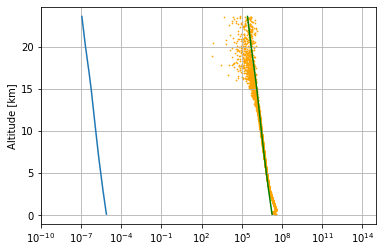

In [699]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((n_s355)*n_alt*n_alt, n_alt*1e-3, c='orange', s=0.5)
plt.semilogx(model*a*meteo_alt*meteo_alt, meteo_alt*1e-3, c='green')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)
plt.savefig('fig8', dpi=200)

In [700]:
%run fernald_new1.ipynb

# Devemos sempre entrar com vetores coluna no algoritmo de inversao

zref = np.array([6*1e3, 14*1e3])
LR = 28.

z = n_alt[..., None]
pr = n_s355[..., None]
ref = zref[..., None]
lambd = 355*1e-9
LidarRatio = LR
Pair = newPair[..., None]
Tair = newTair[..., None]


beta_par, alpha_par, LR_par, model_mol, ab_fit = fernald_new1(z,pr,ref,lambd,LidarRatio,Pair,Tair)

## Devemos restringir o plot a partir de 750m porque antes o overlap varia mto

In [701]:
lim = 100
beta_par['aer'] = beta_par['aer'][lim:]
beta_par['mol'] = beta_par['mol'][lim:]
beta_par['tot'] = beta_par['tot'][lim:]
n_alt = n_alt[lim:]

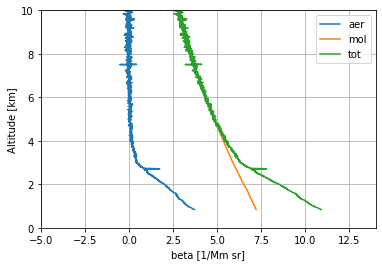

In [705]:
plt.plot((beta_par['aer'])*1e6, n_alt*1e-3)
plt.plot(beta_par['mol']*1e6, n_alt*1e-3)
plt.plot(beta_par['tot']*1e6, n_alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
plt.xlim(-5, 14)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm sr]')
plt.ylabel('Altitude [km]')
plt.savefig('backscatter', dpi=200)